<a href="https://colab.research.google.com/github/vigneshjayanth00/Football/blob/master/Data_Analysis_and_Descriptive_Stats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:

import pandas as pd
import numpy as np
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import IncrementalPCA
%matplotlib inline

from adjustText import adjust_text

In [0]:
data=pd.read_csv(r'C:\Users\Home\Downloads\All Fifa Datasets\Updated Dataset after Cleaning\Updated1.csv')
data.shape


(97339, 80)

In [0]:
from scipy.stats import wilcoxon
import random

Value_18=random.sample(list(data['value_eur']), 60000)  
Value_19=random.sample(list(data['wage_eur']), 60000)
# compare samples
stat, p = wilcoxon(Value_18, Value_19)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Same distribution (fail to reject H0)')
else:
    print('Different distribution (reject H0)')

Statistics=37663696.000, p=0.000
Different distribution (reject H0)


In [0]:
Find=data[['overall','value_eur','wage_eur']]


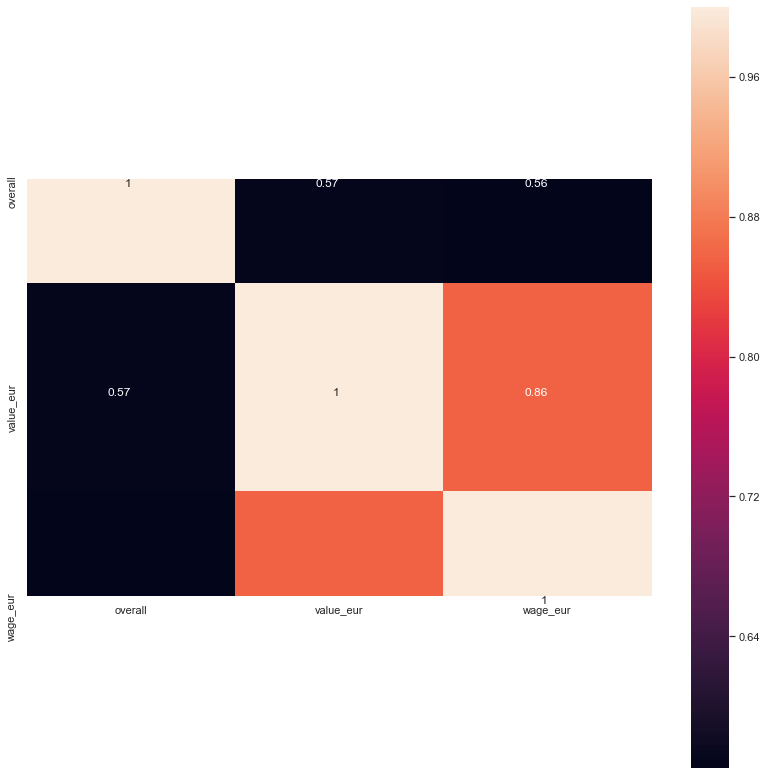

In [0]:
#Identifyinf correlation between all variables (features)
corr = Find.corr()

plt.figure(figsize=(14, 14))
annot_kws = {"ha": 'right',"va": 'top'}
sns.heatmap(corr,annot=True,square=True,xticklabels=True,yticklabels=True)

In [0]:
data.preferred_foot.unique()

array(['Right', 'Left'], dtype=object)

In [0]:

s=pd.get_dummies(data.preferred_foot)
print (s)

       Left  Right
0         0      1
1         0      1
2         1      0
3         1      0
4         0      1
...     ...    ...
97334     1      0
97335     0      1
97336     0      1
97337     0      1
97338     1      0

[97339 rows x 2 columns]


In [0]:
#Encoding Ordinal Categorical Variables: Work Rate and Body Type
Dict={ 'High/Medium':2,'Medium/Low':6, 'Medium/Medium':5, 'High/High':1,
       'High/Low':3, 'Medium/High':4, 'Low/High':7, 'Low/Medium':8, 'Low/Low':9}

data['work_rate']=data['work_rate'].map(Dict)
data.work_rate.unique()

array([2, 6, 5, 1, 3, 4, 7, 8, 9], dtype=int64)

In [0]:
remove_cols=['Unnamed: 0','nationality','preferred_foot','body_type','Year']

df1 = data[data.columns.difference(remove_cols)]

In [0]:
#First need to seperate midfielders, strikers and defenders
Attacking_positions=['LW','RW','ST','RS','LS','CF','RF','LF']
Defensive_positions=['LCB','RCB','RB','LB','CB','RWB','LWB']
Midfield_positions=['CAM','RCM','LM','LCM','RM','LDM','RDM','CDM','CM','RAM','LAM']

Attackers=df1[df1['team_position'].isin(Attacking_positions)]
Defenders=df1[df1['team_position'].isin(Defensive_positions)]
Midfielders=df1[df1['team_position'].isin(Midfield_positions)]
print(Defenders.shape)
print(Attackers.shape)
print(Midfielders.shape)

(14579, 75)
(6523, 75)
(15282, 75)


In [0]:
#Use Names later: Attackers, Defenders, Attackers
Attackers_names = Attackers['short_name'].tolist()
Defenders_names = Defenders['short_name'].tolist()
Midfielders_names = Midfielders['short_name'].tolist()

Attackers_position= Attackers['team_position'].tolist()
Defenders_position= Defenders['team_position'].tolist()
Midfielders_position= Midfielders['team_position'].tolist()

Attackers_club= Attackers['club'].tolist()

Attackers_overall= Attackers['overall'].tolist()
Defenders_overall= Defenders['overall'].tolist()
Midfielders_overall= Midfielders['overall'].tolist()
Attackers_position= Attackers['team_position'].tolist()

del Midfielders['team_position']
del Attackers['club']
del Attackers['team_position']
del Defenders['team_position']
del Midfielders['short_name']
del Attackers['short_name']
del Defenders['short_name']

In [0]:
#K means Clustering

from sklearn import preprocessing

x = Attackers.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()  # could also test using the StandardScaler()
x_scaled = min_max_scaler.fit_transform(x)
X_norm = pd.DataFrame(x_scaled)

###We need to reduce all the 74 dimensions of the X_norm dataframe into 2, so will use PCA to do this.
###This essentially turns a set of correlated features into a set of linearly uncorrelated ones, capturing the greatest variablity between features. Of course now, the 2 PCA dimensions on their own are fairly meaningless

pca = sklearnPCA(n_components=2) #2-dimensional PCA
transformed = pd.DataFrame(pca.fit_transform(X_norm))


In [0]:
#One major factor to consider in K-means clustering is the number of clusters the final grouping should have.
#One method to determine this is via the 'elbow method'. Essentially plotting number of clusters against the sum of squared errors. A good number of clusters to choose is at the plot's "elbow" - the point where adding another cluster doesn't reduce the sum of squared errors too much. 
#It gives a fairly good approximation but is not foolproof, so knowledge of the data helps with this too

cluster_range = range(1, 11 )
cluster_errors = []

for num_clusters in cluster_range:
    clusters = KMeans( num_clusters )
    clusters.fit( transformed )
    cluster_errors.append( clusters.inertia_ )

clusters_df = pd.DataFrame( { "num_clusters":cluster_range, "cluster_errors": cluster_errors } )

clusters_df


,num_clusters,cluster_errors
0,1,5229.589564
1,2,2754.704150
2,3,2024.968354
3,4,1539.816698
4,5,1257.431429
5,6,1077.463518
6,7,936.316081
7,8,830.121381
8,9,745.624614
9,10,676.251517


Text(0, 0.5, 'Sum of squared errors')

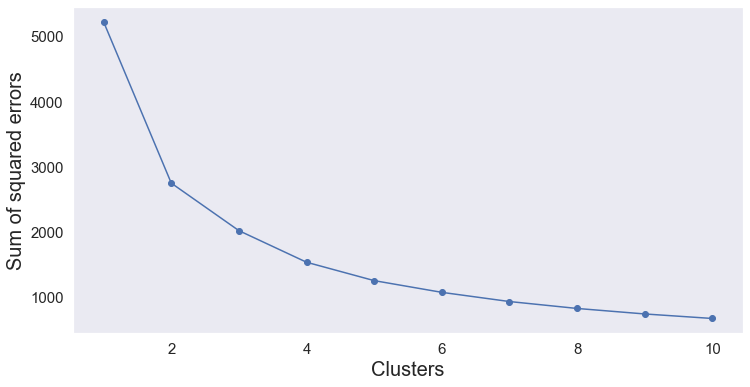

In [0]:
#Plotting the number of clusters using the elbow method

sns.set(style="dark")
plt.figure(figsize=(12,6))
plt.plot( clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o" )
plt.tick_params(labelsize=15)

plt.xlabel("Clusters", fontsize=20)
plt.ylabel("Sum of squared errors", fontsize=20)

In [0]:
#Examining the "elbow" and after a few few trial-and-error runs, 5 clusters should be appropriate
#Perform K-means clustering on the PCA reduced dataframe, with 5 clusters:

# Number of clusters
kmeans = KMeans(n_clusters=5)
# Fitting the input data
kmeans = kmeans.fit(transformed)
# Getting the cluster labels
labels = kmeans.predict(transformed)
# Centroid values
C = kmeans.cluster_centers_
clusters = kmeans.labels_.tolist()

In [0]:
#add the calculated cluster and player names back to the transformed PCA dataframe

transformed['cluster'] = clusters
transformed['name'] = Attackers_names
transformed['position'] = Attackers_position
transformed['Overall_Rating'] = Attackers_overall
transformed['Club']=Attackers_club
transformed.columns = ['x','y','cluster','name','position','Overall_Rating','Club']
remove=['SUB','RES']
transformed1=transformed[~(transformed.position.isin(remove))]
transformed2=transformed1.drop_duplicates(subset='name', keep="first")
transformed2[:20]

,x,y,cluster,name,position,Overall_Rating,Club
0,2.338863,-0.798614,4,Neymar,LW,92,Paris Saint-Germain
1,2.401475,-1.107672,4,L. Messi,RW,94,FC Barcelona
5,2.543574,-0.201891,4,L. Suárez,ST,92,FC Barcelona
6,2.706933,-0.700190,4,Cristiano Ronaldo,LW,94,Real Madrid
8,2.373877,-0.633565,4,K. Mbappé,RW,89,Paris Saint-Germain
9,2.386676,-0.618205,4,E. Hazard,LW,91,Chelsea
10,2.114412,-0.342971,4,R. Lewandowski,ST,91,FC Bayern München
14,2.050719,-0.844056,4,P. Dybala,RW,89,Juventus
16,2.099609,0.050363,4,H. Kane,ST,89,Tottenham Hotspur
19,2.438497,-0.193606,4,M. Salah,RW,90,Liverpool


In [0]:
#Similar cluster and position: Sort by Overall Rating
transformed2=transformed2.sort_values(['Overall_Rating','cluster'], ascending=[False,True])
cluster1=transformed2[(transformed2.position=='LW') & (transformed2.cluster==4)]

#Top 100 players for Cluster=4 and Position==LW
cluster2=cluster1[:15]
cluster2

,x,y,cluster,name,position,Overall_Rating,Club
6,2.706933,-0.700190,4,Cristiano Ronaldo,LW,94,Real Madrid
0,2.338863,-0.798614,4,Neymar,LW,92,Paris Saint-Germain
9,2.386676,-0.618205,4,E. Hazard,LW,91,Chelsea
37,2.286313,-0.253212,4,A. Sánchez,LW,89,Arsenal
27,2.232525,0.343557,4,R. Sterling,LW,88,Manchester City
45,1.877723,-0.662281,4,L. Insigne,LW,88,Napoli
47,2.195340,-0.449237,4,S. Mané,LW,88,Liverpool
43,1.853781,-0.390600,4,L. Sané,LW,86,Manchester City
211,1.796563,-0.706329,4,F. Ribéry,LW,86,FC Bayern München
58,1.905325,-0.189663,4,Marco Asensio,LW,85,Real Madrid


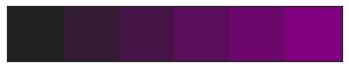

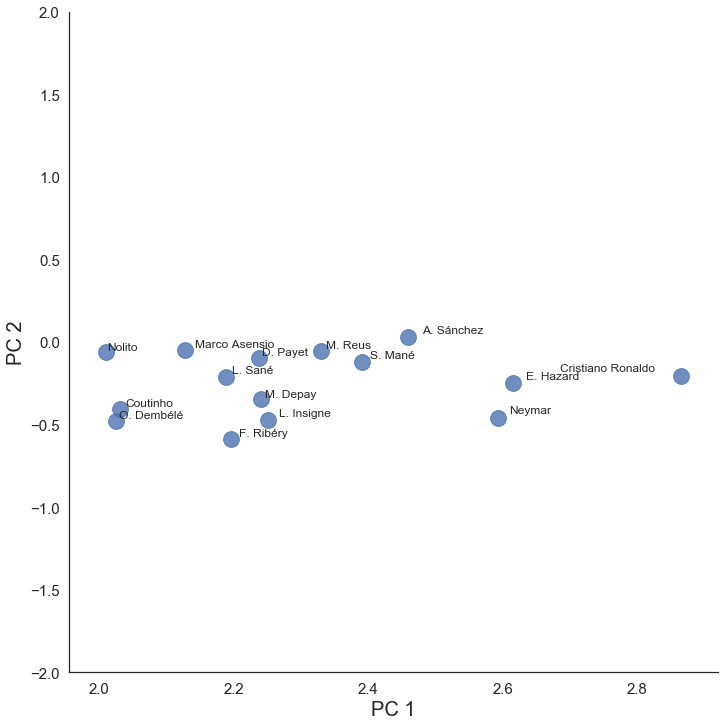

In [0]:
sns.set(style="white")
pal =  sns.palplot(sns.dark_palette("purple"))

ax = sns.lmplot(x="x", y="y",hue='cluster', data=cluster2, legend=False,
                   fit_reg=False, height =10, scatter_kws={"s": 250}, palette=pal)

texts = []
for x, y, s in zip(cluster2.x, cluster2.y, cluster2.name):
    texts.append(plt.text(x, y, s))
    adjust_text(texts) #, arrowprops=dict(arrowstyle="->", color='r', lw=0.5))  # uncomment to add arrows to labels

#ax._legend.set_title(prop={fontsize:'15'})
ax.set(ylim=(-2, 2))
plt.tick_params(labelsize=15)
#plt.setp(ax.get_legend().get_title(), fontsize='15')
plt.xlabel("PC 1", fontsize=20)
plt.ylabel("PC 2", fontsize=20)

plt.show()
# ax.savefig("newc_man_kmeans.jpg")

In [0]:
import numpy as np
from sklearn.neighbors import KDTree

#Looking for closest players in terms of similarity for M. Reus
#Ind=cluster2[cluster2.name=='Neymar'].index
Ind = list(np.where(cluster2["name"] =='Neymar')[0])
c=cluster2.iloc[:,:2]
tree = KDTree(c, leaf_size=2)

print(Ind)

[1]


In [0]:
select_indices=[]
for i in Ind:
    ind = tree.query_radius(c[:i], r=0.9)  # doctest: +SKIP
    select_indices=list(ind)

for i in select_indices:
    Similar_Players=transformed2.iloc[i]
    



,x,y,cluster,name,position,Overall_Rating
30,2.636093,0.674503,3,G. Bale,RW,90
9,2.615434,-0.250843,4,E. Hazard,LW,91
16,2.283803,0.237763,3,H. Kane,ST,89
20,2.563554,0.146283,3,M. Salah,RW,90
25,1.995562,-0.708726,4,G. Higuaín,ST,90
6,2.865145,-0.204821,4,Cristiano Ronaldo,LW,94
5,2.613461,0.160444,3,L. Suárez,ST,92
1,2.716829,-0.639425,4,L. Messi,RW,94
0,2.592858,-0.459237,4,Neymar,LW,92
10,2.353444,-0.073161,4,R. Lewandowski,ST,91


In [0]:
Attacking_cols=list(data.filter(regex='attackin|short_name').columns)
skill_cols=list(data.filter(regex='skill|short_name').columns)
movement_cols=list(data.filter(regex='movement|short_name').columns)
power_cols=list(data.filter(regex='power|short_name').columns)
mentality_cols=list(data.filter(regex='mentality|short_name').columns)
Attributes_cols=['short_name','age','height_cm','weight_kg','nationality','club','overall',
'potential','value_eur','wage_eur','preferred_foot','international_reputation','weak_foot',
'skill_moves','work_rate','body_type','team_position','pace','shooting','passing',
'dribbling','defending','physic']



power_cols



['short_name',
 'power_shot_power',
 'power_jumping',
 'power_stamina',
 'power_strength',
 'power_long_shots']

In [0]:
Attacking=data[power_cols]
Names1=['Coutinho','F. Ribéry']
Names2=['E. Hazard','Cristiano Ronaldo']
Attacking1=Attacking[Attacking.short_name.isin(Names1)]
Attacking2=Attacking[Attacking.short_name.isin(Names2)]
Attacking3 = Attacking1.groupby('short_name',as_index=False).mean()

Attacking4 = Attacking2.groupby('short_name',as_index=False).mean()
Attacking3.columns = Attacking3.columns.str.lstrip('power_')
Attacking4.columns = Attacking4.columns.str.lstrip('power_')
Attacking3.rename({'short_name':'Name'},axis=1, inplace=True)
Attacking4.rename({'short_name':'Name'},axis=1, inplace=True)
#Attacking3.columns = ['Name','Crossing', 'Finishing','Heading Accuracy','Short Passing','Volleys']
Attacking3
#Attacking4

,Name,shot_power,jumping,stamina,strength,long_shots
0,Coutinho,78.833333,60.833333,74.0,60.0,80.833333
1,F. Ribéry,75.800000,43.800000,64.6,60.6,73.200000


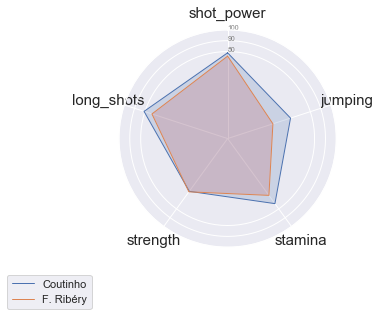

In [0]:
import matplotlib.pyplot as plt
import pandas as pd
from math import pi

# ------- PART 1: Create background
 
# number of variable
categories=list(Attacking3)[1:]
N = len(categories)
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
ax = plt.subplot(111, polar=True)
 
# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
# Draw one axe per variable + add labels labels yet
plt.xticks(angles[:-1], categories,size=15)
 
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([80,90,100], ["80","90","100"], color="grey", size=7)
plt.ylim(0,100)
 
 
# ------- PART 2: Add plots
 
# Plot each individual = each line of the data
 
# Ind1
values=Attacking3.loc[0].drop('Name').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="Coutinho")
ax.fill(angles, values, 'b', alpha=0.2)

 
# Ind2
values=Attacking3.loc[1].drop('Name').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="F. Ribéry")
ax.fill(angles, values, 'r', alpha=0.2)
 
# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(-0.1, -0.1))



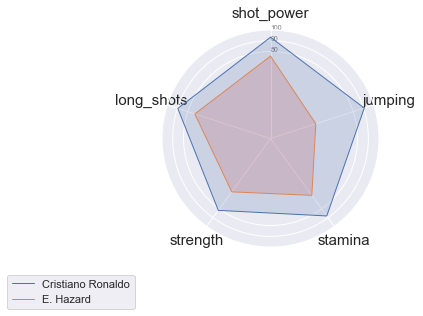

In [0]:
import matplotlib.pyplot as plt
import pandas as pd
from math import pi

# ------- PART 1: Create background
 
# number of variable
categories=list(Attacking4)[1:]
N = len(categories)
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
ax = plt.subplot(111, polar=True)
 
# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
# Draw one axe per variable + add labels labels yet
plt.xticks(angles[:-1], categories,size=15)
 
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([80,90,100], ["80","90","100"], color="grey", size=7)
plt.ylim(0,100)
 
 
# ------- PART 2: Add plots
 
# Plot each individual = each line of the data
 
# Ind1
values=Attacking4.loc[0].drop('Name').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label='Cristiano Ronaldo')
ax.fill(angles, values, 'b', alpha=0.2)

 
# Ind2
values=Attacking3.loc[1].drop('Name').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label='E. Hazard')
ax.fill(angles, values, 'r', alpha=0.2)
 
# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(-0.1, -0.1))



In [0]:
club_list=list(data['club'].unique())
club_list=club_list[:10]

Index(['Unnamed: 0', 'short_name', 'age', 'height_cm', 'weight_kg',
       'nationality', 'club', 'overall', 'potential', 'value_eur', 'wage_eur',
       'preferred_foot', 'international_reputation', 'weak_foot',
       'skill_moves', 'work_rate', 'body_type', 'team_position', 'pace',
       'shooting', 'passing', 'dribbling', 'defending', 'physic',
       'attacking_crossing', 'attacking_finishing',
       'attacking_heading_accuracy', 'attacking_short_passing',
       'attacking_volleys', 'skill_dribbling', 'skill_curve',
       'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control',
       'movement_acceleration', 'movement_sprint_speed', 'movement_agility',
       'movement_reactions', 'movement_balance', 'power_shot_power',
       'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots',
       'mentality_aggression', 'mentality_interceptions',
       'mentality_positioning', 'mentality_vision', 'mentality_penalties',
       'mentality_composure', 'defending

In [0]:
df = data[['club','team_position','overall','value_eur']]

df1=df[df['club'].isin(club_list)]
df1.rename({'value_eur':'Value','overall':'Overall Rating','team_position':'Player Position'},axis=1, inplace=True)
remove=['SUB','RES']
df1=df1[~(df1['Player Position'].isin(remove))]

bin_labels_5 = ['Bronze', 'Silver', 'Gold', 'Platinum', 'Diamond','Elite','Master','Grandmaster']
df1['Value'] = pd.qcut(df1['Value'],
                              q=[0, .2, .4, .5, .6, .8,.85, .9, 1],
                              labels=bin_labels_5)


df2=df1[['club','Overall Rating']]

dfnm = df2.groupby('club').transform(lambda x: (x-min(x)) / (max(x)-min (x)))
df1['overall']=dfnm
club_list=list(df1.club.unique())
club_list

['Paris Saint-Germain',
 'FC Barcelona',
 'Manchester City',
 'Real Madrid',
 'Chelsea',
 'FC Bayern München',
 'Juventus',
 'Tottenham Hotspur',
 'Liverpool',
 'Atlético Madrid']

In [0]:
import plotly.express as px

#Select Team

for i in club_list:  
    
        
    fig = px.bar_polar(df1[df1.club==i], r="Overall Rating", theta="Player Position",
               color="Value", template="plotly_dark",
               color_discrete_sequence= px.colors.sequential.Plasma)
    fig.update_layout(
    title='Player Value Distribution by Position: '+str(i),
    font_size=16)

    fig.add_annotation(
            x=4.2,
            y=7,
            text="Neymar")

    fig.update_annotations(dict(
            xref="x",
            yref="y",
            showarrow=True,
            arrowhead=7,
            ax=5,
            ay=-90
))

    fig.show()
